# **Imports**

In [1]:
import pandas as pd
from openpyxl import load_workbook
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from pydantic import BaseModel, ConfigDict
from tqdm import tqdm


# **Constants**

In [2]:
@dataclass(frozen=True)
class Pathes:
    path_turn_on_off_heating: str = '../main_datasets/processed_datasets/6. Плановые-Внеплановые отключения 01.10.2023-30.04.2023.csv'
    path_events_for_period_2023_params: str = '../main_datasets/processed_datasets/События за период_01.10.2023-31.12.2023____pivot_table.csv'
    path_events_for_period_2023: str = '../main_datasets/processed_datasets/События за период_01.10.2023-31.12.2023.xlsx____uploading_table.csv'
    path_events_for_period_2024: str = '../main_datasets/processed_datasets/События_за_период_01.01.2024-30.04.2024____uploading_table.csv'
    path_events_for_period_2024_params: str = '../main_datasets/processed_datasets/События_за_период_01.01.2024-30.04.2024____pivot_table.csv'


In [3]:
date_columns =  [
    'Дата создания во внешней системе', 'Дата закрытия', 'Дата и время завершения события во внешней системе',
    'Дата регистрации отключения', 'Планируемая дата отключения', 'Планируемая дата включения', 'Фактическая дата отключения'
    'Фактическая дата включения'
]

In [4]:
usfull_building_params = [
    'Серии проектов', 'Количество этажей', 'Количество подъездов', 'Количество квартир',
    'Общая площадь', 'Общая площадь жилых помещений',
    'Общая площадь нежилых помещений', 'Износ объекта (по БТИ)',
    ' Материалы стен', 'Признак аварийности здания',
    'Количество пассажирских лифтов', 'Количество грузопассажирских лифтов',
    'Очередность уборки кровли', 'Материалы кровли по БТИ',
    'Типы жилищного фонда', 'Статусы МКД'
]

# **Functions**

In [5]:
def date_columns_to_date_format(df: pd.DataFrame) -> pd.DataFrame:
    for i in date_columns:
        if i in df.columns:
            df[i] = pd.to_datetime(df[i])
    return df

In [6]:
def load_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = date_columns_to_date_format(df)
    return df

In [7]:
def make_timeline_for_year(year: int=2023):
    data_1 = np.arange(datetime(year=year, month=1, day=1), datetime(year=year, month=5, day=1), timedelta(hours=1)).tolist()
    data_2 = np.arange(datetime(year=year, month=10, day=1), datetime(year=year+1, month=1, day=1), timedelta(hours=1)).tolist()
    return np.array(data_1+data_2)


def make_timeline_for_period(year: int=2022, delta=1):
    s = datetime(year=year, month=10, day=1)
    e = datetime(year=year+1, month=5, day=1)
    data = np.arange(s, e, timedelta(hours=delta)).tolist()
    return data

In [8]:
def address_compare(a1_BTI, a2_BTI):
    a1_BTI = a1_BTI.replace('город Москва, ', '').lower().split(', ')[1:]
    a2_BTI = a2_BTI.replace('город Москва, ', '').lower().split(', ')
    for a1_i, a2_i in zip(a1_BTI, a2_BTI):
        if a1_i != a2_i:
            return False
    return True

    

In [9]:
def make_anomaly_ts(year: int, events: pd.DataFrame):
    time_line = make_timeline_for_period(year)
    anomaly = [any([i.month == j.month and i.day == j.day and i.hour == j.hour for j in events['Дата создания во внешней системе']]) for i in time_line]
    nd = pd.DataFrame({'time': time_line, 'anomaly': anomaly})
    return nd
    

# **Loading tables**

In [10]:
turn_on_off_heating = load_dataset(Pathes.path_turn_on_off_heating)
events_for_period_2023 = load_dataset(Pathes.path_events_for_period_2023)
events_for_period_2024 = load_dataset(Pathes.path_events_for_period_2024)
events_for_period_2023_params = load_dataset(Pathes.path_events_for_period_2023_params)
events_for_period_2024_params = load_dataset(Pathes.path_events_for_period_2024_params)


In [11]:
usefull_events = events_for_period_2024_params['Названия строк'].to_list()

In [12]:
events_for_period_2023__only_usefull_events = events_for_period_2023.loc[events_for_period_2023['Наименование'].isin(usefull_events)]
events_for_period_2024__only_usefull_events = events_for_period_2024.loc[events_for_period_2024['Наименование'].isin(usefull_events)]

In [13]:
df = events_for_period_2024__only_usefull_events
df.columns = events_for_period_2023__only_usefull_events.columns
all_in_one_events = pd.concat(
    [
        events_for_period_2023__only_usefull_events, 
        df
    ],
    axis=0
)

# **Events analize**

## By freq

In [14]:
mp = 0
k = -1
t = -1
for i in tqdm(np.unique(all_in_one_events['УНОМ'])):
    # for j in all_in_one_events['Дата создания во внешней системе']:
        # x1 = all_in_one_events['Дата создания во внешней системе']==j
    x2 = all_in_one_events['УНОМ'] == i
    p = pd.to_datetime(all_in_one_events['Дата создания во внешней системе'][x2])
    x, y = np.unique(p.map(lambda a: a.round(freq='d')), return_counts=True)
    if len(y):
        m = max(y)
        if m > mp:
            mp = m
            k = i
            t = x[np.argmax(y)]


  0%|          | 0/4340 [00:00<?, ?it/s]

100%|██████████| 4340/4340 [00:04<00:00, 878.54it/s] 


In [15]:
mp, k, t

(109, 3789.0, numpy.datetime64('2024-01-13T00:00:00.000000000'))

In [16]:
d = (all_in_one_events[all_in_one_events['УНОМ'] == k]['Дата создания во внешней системе']).map(lambda a: a.round(freq='d'))
d = pd.to_datetime(d) == t

In [17]:
sum(d)

109

In [18]:
tds = all_in_one_events[all_in_one_events['УНОМ'] == k][d]
tds.iloc[np.argsort(tds['Дата создания во внешней системе'])]['Наименование'].unique()

array(['Температура в квартире ниже нормативной',
       'Течь в системе отопления'], dtype=object)

## By types

In [19]:
all_in_one_events['h'] = all_in_one_events['Дата создания во внешней системе'].map(lambda a: a.round(freq='h'))
all_in_one_events['d'] = all_in_one_events['Дата создания во внешней системе'].map(lambda a: a.round(freq='d'))


In [115]:
max_num_of_events = 0
unm_id = -1
time_ = -1
for i in tqdm(np.unique(all_in_one_events['УНОМ'])):
    l1 = all_in_one_events['УНОМ'] == i
    for j in np.unique(all_in_one_events['d'][l1]):
        l2 = (all_in_one_events['d'] == j) & l1
        x = np.unique(all_in_one_events['Наименование'][l2])
        if len(x):
            m = len(x)
            if m > max_num_of_events:
                max_num_of_events = m
                unm_id = i
                time_ = j




  0%|          | 0/4340 [00:00<?, ?it/s]

100%|██████████| 4340/4340 [01:01<00:00, 70.13it/s] 


In [118]:
max_num_of_events, unm_id, time_

(6, 24603.0, numpy.datetime64('2024-01-05T00:00:00.000000000'))

In [120]:
np.unique(all_in_one_events[all_in_one_events['УНОМ'] == unm_id]['Наименование'])

array(['Отсутствие отопления в доме', 'Протечка труб в подъезде',
       'Сильная течь в системе отопления',
       'Температура в квартире ниже нормативной',
       'Температура в помещении общего пользования ниже нормативной',
       'Течь в системе отопления'], dtype=object)

<Axes: >

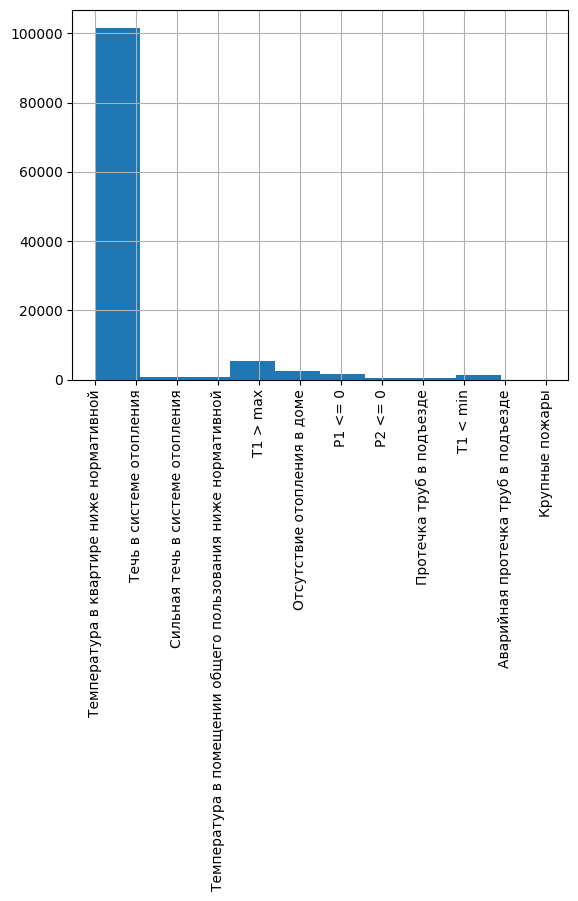

In [124]:
plt.xticks(rotation=90)
all_in_one_events['Наименование'].hist()

# **Modulate ts**

In [20]:
anomaly_in_day = all_in_one_events['d']

In [21]:
anomaly_in_day = pd.DataFrame()

In [55]:
years = [2022, 2023, 2024]
# year = 2023
l = dict()

for unom_id in tqdm(np.unique(all_in_one_events['УНОМ'])):
    l[int(unom_id)] = dict()
    unom_id_events = all_in_one_events[all_in_one_events['УНОМ'] == unom_id]
    for year in years:
        tl = make_timeline_for_period(year, delta=24)
        tl_df = pd.Series(np.zeros_like(tl), index=tl, name='n_of_event')
        # tl_df.index = tl_df.index.map(lambda a: a.to_pydatetime())
        ud = np.unique(unom_id_events['d'].to_list())
        for d in ud:
            tl_df.loc[tl_df.index==d] += 1
        l[int(unom_id)][year] = {str(i): j for i, j in zip(tl_df.index, tl_df.values)}
    # if len(l) == 15:
    #     break

  0%|          | 0/4340 [00:00<?, ?it/s]

100%|██████████| 4340/4340 [01:15<00:00, 57.67it/s] 


In [56]:
import json


with open('../main_datasets/timelines_datasets/events_counts_time_lines.json', 'w') as f:
    json.dump(l, f, default=str)